## Patrick provided a pair of images from AuxTel.
### Let's look at how those images work with our cwfs code

### load the modules

In [2]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Define the image objects. Input arguments: file name, field coordinates in deg, image type
The colorbar() below may produce a warning message if your matplotlib version is older than 1.5.0
( https://github.com/matplotlib/matplotlib/issues/5209 )

In [3]:
fieldXY = [0,0]

I1 = Image(readFile('../tests/testImages/AuxTel/I1_intra_20190912_HD21161_z05.fits'), fieldXY, Image.INTRA)
I2 = Image(readFile('../tests/testImages/AuxTel/I2_extra_20190912_HD21161_z05.fits'), fieldXY, Image.EXTRA)

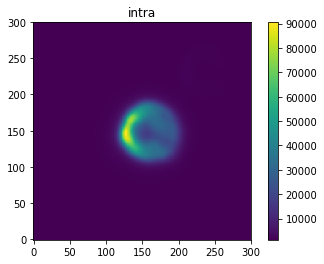

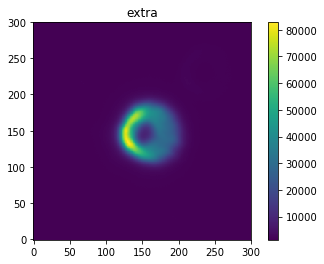

In [4]:
plots.plotImage(I1.image,'intra')
plots.plotImage(I2.image,'extra')

### Define the instrument. Input arguments: instrument name, size of image stamps

In [5]:
inst=Instrument('AuxTel',I1.sizeinPix)

### Define the algorithm being used. Input arguments: baseline algorithm, instrument, debug level

In [6]:
algo=Algorithm('exp',inst,0)

### Run it

In [7]:
algo.runIt(inst,I1,I2,'paraxial')

### Print the Zernikes Zn (n>=4)

In [8]:
print(algo.zer4UpNm)

[ -2.92472450e+00   6.32757824e+00  -7.52973077e+00   2.58455156e+01
  -1.91518636e+02   4.37420290e+01   3.52104101e+01  -6.88763674e+00
   6.32179299e+00  -2.28357982e+00   1.82545993e-01   1.09564150e+00
   1.37480919e+01  -5.74133498e+00   3.09618053e+00  -1.20836266e+00
   3.59231244e+00   4.21150086e+00   1.48604629e+00]


### plot the Zernikes Zn (n>=4)

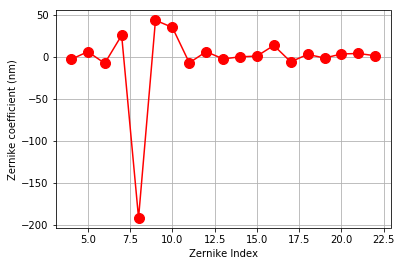

In [9]:
plots.plotZer(algo.zer4UpNm,'nm')

### We check that the optical parameters provided are consistent with the image diameter. Otherwise the numerical solutions themselves do not make much sense.

In [10]:
print("Expected image diameter in pixels = %.0f"%(inst.offset/inst.fno/inst.pixelSize))

Expected image diameter in pixels = 79


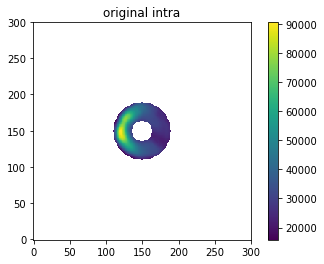

In [11]:
plots.plotImage(I1.image0,'original intra', mask=algo.pMask)

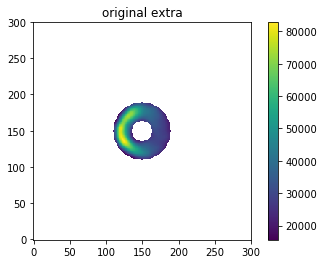

In [12]:
plots.plotImage(I2.image0,'original extra', mask=algo.pMask)

### Patrick asked the question: can we show the results of the fit in intensity space, and also the residual?

Great question. The short answer is no.

The long answer: the current approach implemented is the so-called inversion approach, i.e., to inversely solve the Transport of Intensity Equation with boundary conditions. It is not a forward fit. If you think of the unperturbed image as I0, and the real image as I, we iteratively map I back toward I0 using the estimated wavefront. Upon convergence, our "residual images" should have intensity distributions that are nearly uniform. We always have an estimated wavefront, and a residual wavefront. The residual wavefront is obtained from the two residual images.

However, using tools availabe in the cwfs package, we can easily make forward prediction of the images using the wavefront solution. This is basically to take the slope of the wavefront at any pupil position, and raytrace to the image plane. We will demostrate these below.

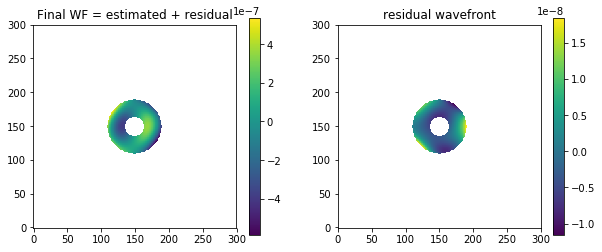

In [13]:
nanMask = np.ones(I1.image.shape)
nanMask[I1.pMask==0] = np.nan
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(algo.Wconverge*nanMask, origin='lower')
ax[0].set_title('Final WF = estimated + residual')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(algo.West*nanMask, origin='lower')
ax[1].set_title('residual wavefront')
fig.colorbar(img, ax=ax[1])

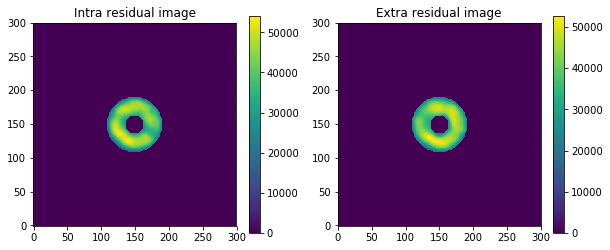

In [14]:
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(I1.image, origin='lower')
ax[0].set_title('Intra residual image')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(I2.image, origin='lower')
ax[1].set_title('Extra residual image')
fig.colorbar(img, ax=ax[1])

#### Now we do the forward raytrace using our wavefront solutions
The code is simply borrowed from existing cwfs code.

#### We first set up the pupil grid. Oversample means how many ray to trace from each grid point on the pupil.

In [15]:
oversample = 10
projSamples = I1.image0.shape[0]*oversample

luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

#### We now trace the rays to the image plane. Lutxp and Lutyp are image coordinates for each (oversampled) ray. showProjection() makes the intensity image. Then, to down sample the image back to original resolution, we want to use the function downResolution() which is defined for the image class.

In [16]:
lutxp, lutyp, J = aperture2image(I1, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I1fit = Image(show_lutxyp, fieldXY, Image.INTRA)
I1fit.downResolution(oversample, I1.image0.shape[0], I1.image0.shape[1])

#### Now do the same thing for extra focal image

In [17]:
luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

lutxp, lutyp, J = aperture2image(I2, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I2fit = Image(show_lutxyp, fieldXY, Image.EXTRA)
I2fit.downResolution(oversample, I2.image0.shape[0], I2.image0.shape[1])

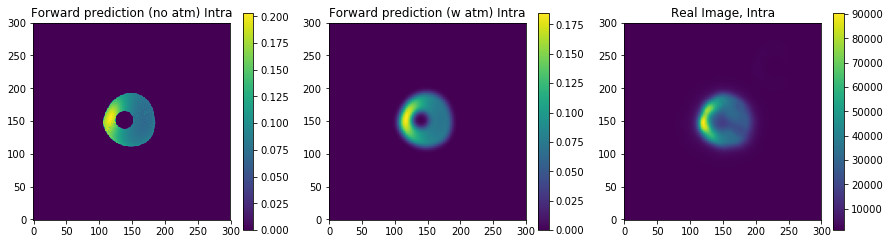

In [20]:
#The atmosphere used here is just a random Gaussian smearing. We do not care much about the size at this point
from scipy.ndimage import gaussian_filter

atmSigma = .6/3600/180*3.14159*21.6/1.44e-5
I1fit.image[np.isnan(I1fit.image)]=0
a = gaussian_filter(I1fit.image, sigma=atmSigma)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I1fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Intra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(a, origin='lower')
ax[1].set_title('Forward prediction (w atm) Intra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I1.image0, origin='lower')
ax[2].set_title('Real Image, Intra')
fig.colorbar(img, ax=ax[2])

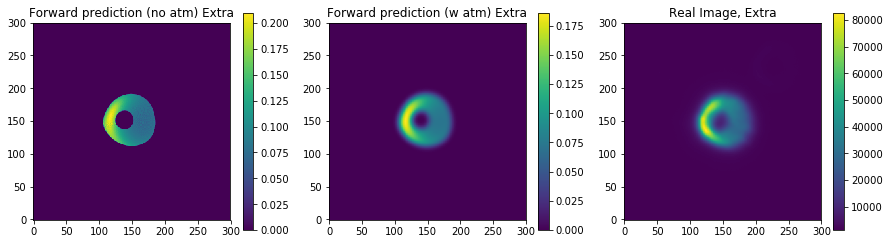

In [21]:
I2fit.image[np.isnan(I2fit.image)]=0
b = gaussian_filter(I2fit.image, sigma=atmSigma)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I2fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Extra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(b, origin='lower')
ax[1].set_title('Forward prediction (w atm) Extra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I2.image0, origin='lower')
ax[2].set_title('Real Image, Extra')
fig.colorbar(img, ax=ax[2])